# Análisis de abandono de clientes básico
Antes de empezar, vamos a cargar las librerías que nos harán falta

In [4]:
import pandas as pd 
import numpy as np
import lightgbm as lgbm
import sklearn as sk
import xgboost as xgb
from sklearn import model_selection
from sklearn import ensemble
from sklearn import preprocessing as sk_prep
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

Vamos a cargar nuestro dataset obtenido de https://www.kaggle.com/kmalit/bank-customer-churn-prediction/data. Además vamos a quitar algunas columnas que no aportan por ser IDs o datos personales como el apellido

In [8]:
#load data from our local data folder
base_path = r"C:\\Users\\Pau\\Desktop\\SolidQ\\Summit 2019\\Churn Norris\\Code\\data\\"
file = "churn_demo.csv"

#drop features that will not be useful, they are either identifiers of the customer or 
#personal information without any relation with their churn likelihood
df_base = pd.read_csv(base_path+file).drop(columns=['RowNumber', 'Surname', 'CustomerId'], axis = 1)

HTML(df_base.head(20).to_html(index = False))


CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
619,France,Female,42,2,0.00,1,1,1,101348.88,1
608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
502,France,Female,42,8,159660.80,3,1,0,113931.57,1
699,France,Female,39,1,0.00,2,0,0,93826.63,0
850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
822,France,Male,50,7,0.00,2,1,1,10062.80,0
376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
501,France,Male,44,4,142051.07,2,0,1,74940.50,0
684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [9]:
#how much data do we have?
print(df_base.shape)

(10000, 11)


In [10]:
#create metadata 
label = 'Exited'
df_columns = list(df_base.columns)
df_columns.remove(label)
print(df_columns)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


# Exploración del dato

Vamos a analizar el dato brevemente con algunos boxplots e histogramas. Podemos hacernos una idea de qué atributos van a tener importancia por sí mismos por cómo separan nuestro label (en este caso, si el cliente abandona o no). Éste análisis puede ser mucho más complejo, y al final, depende del modelo que usemos, es muy probable que encontremos relaciones más complejas entre atributos para predecir el abandono

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


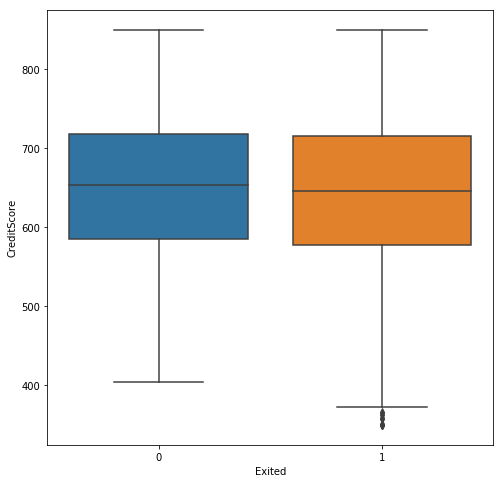

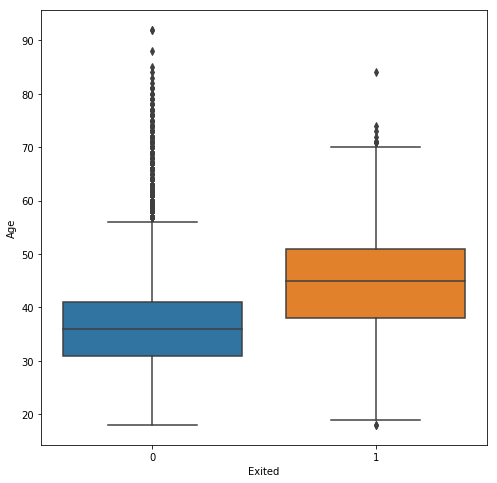

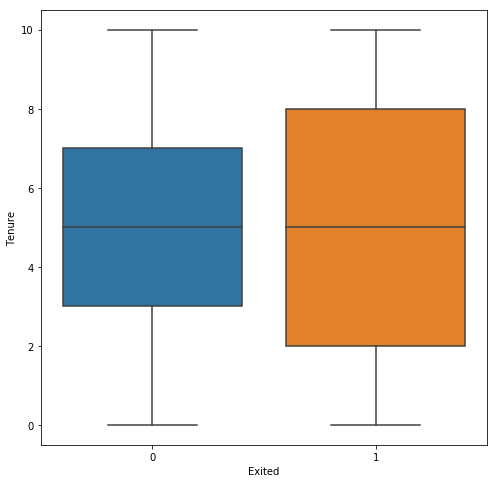

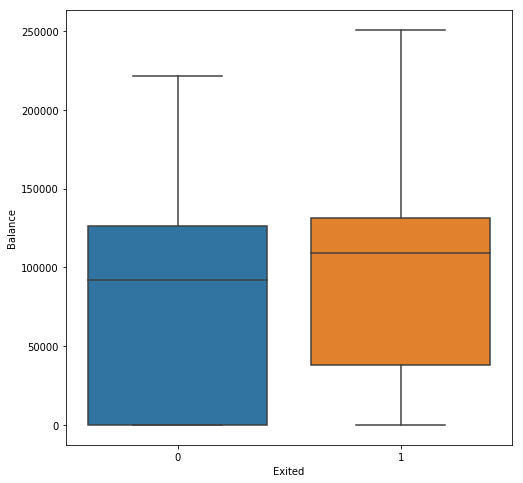

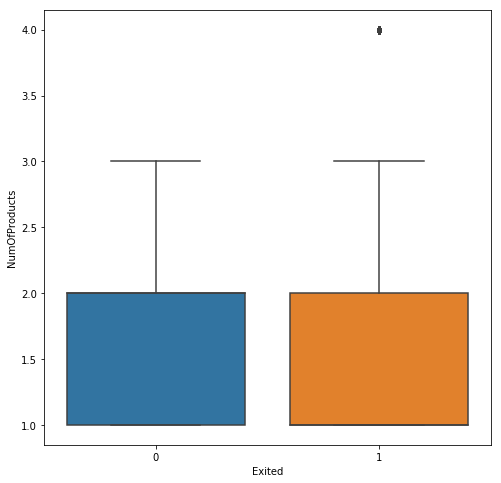

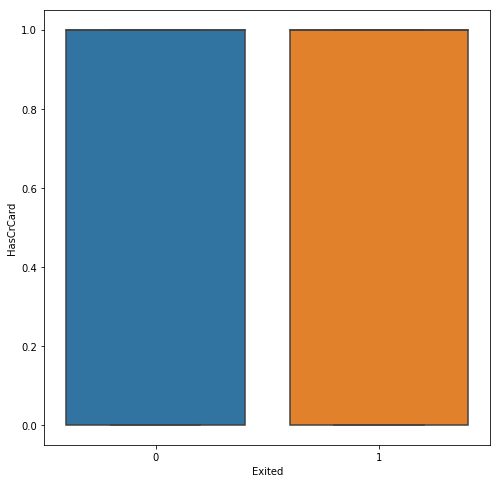

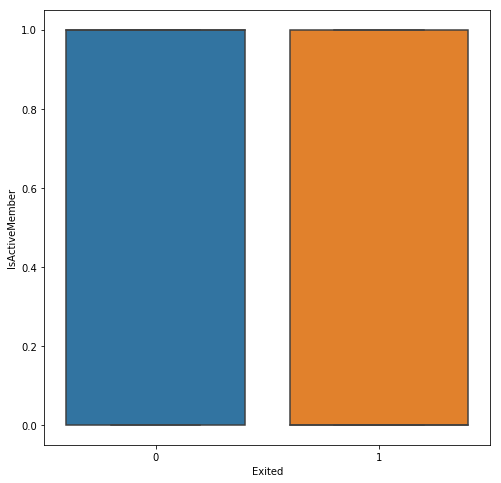

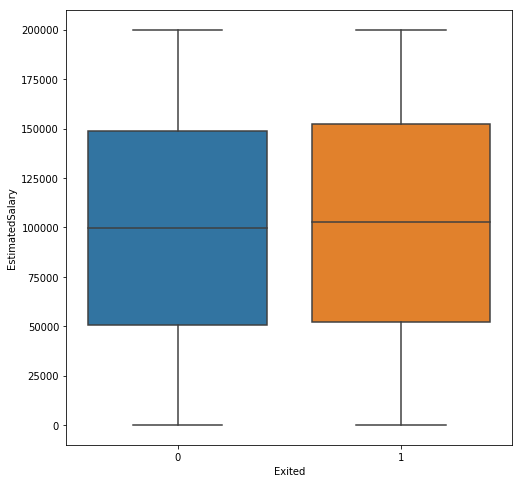

In [11]:
#some EDA 

#detect numeric and categorical data
num_cols = list(df_base._get_numeric_data().columns)
num_cols.remove(label)
#use our numerical columns to find out our categorical columns
cat_cols = list(set(df_base.columns) - set(num_cols))

print(num_cols)

#for numeric cols, plot bloxplots hued by the target
for c in num_cols:
    plt.figure(figsize=(8,8)) #create new figure
    ax = sns.boxplot(x=label, y=c,  data=df_base) #plot histogram


Vemos que tanto la edad como el tenure (permanencia) son dos factores que empiezan a diferenciar el hecho de que un cliente abandone o se quede en nuestro banco. Buena señal! 

['Exited', 'Geography', 'Gender']


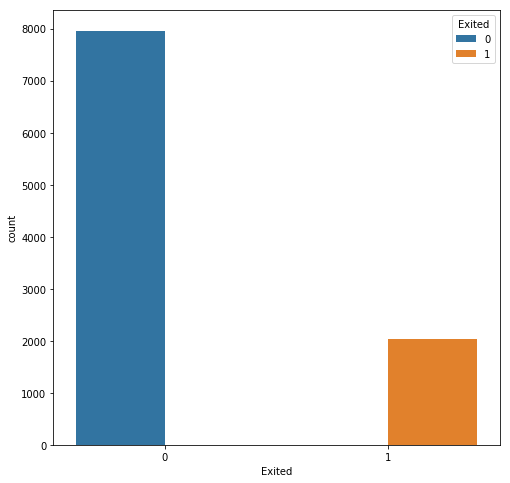

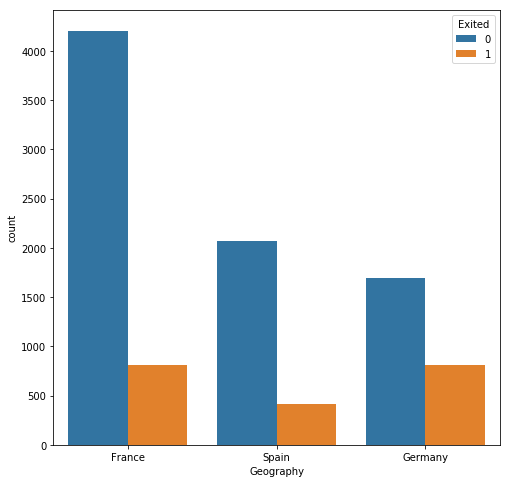

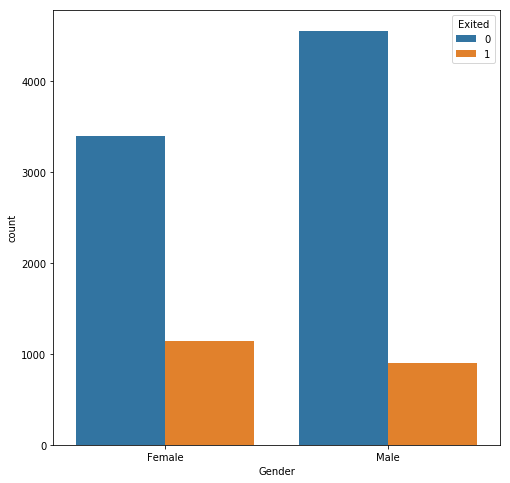

In [12]:
#for categorical data create histograms
print(cat_cols)

for c in cat_cols:
    plt.figure(figsize=(8, 8))
    ax = sns.countplot(x=c, hue=label, data=df_base) 


In [13]:
#encoders. Just for the sake of the demo, other encoding strategies would be beneficial too
l_binarizer = sk_prep.LabelBinarizer()
str_encoder = sk_prep.OrdinalEncoder()

#binarize label
y_encoded = l_binarizer.fit_transform(y=df_base[label])

#encode strings
X_encoded = pd.DataFrame(str_encoder.fit_transform(X=df_base.drop(columns = [label], axis = 1)),
                            columns = df_columns)

X_encoded.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0
5,254.0,2.0,1.0,26.0,8.0,2674.0,1.0,1.0,0.0,7531.0
6,431.0,0.0,1.0,32.0,7.0,0.0,1.0,1.0,1.0,513.0
7,8.0,1.0,0.0,11.0,4.0,2781.0,3.0,1.0,0.0,5978.0
8,110.0,0.0,1.0,26.0,4.0,4962.0,1.0,0.0,1.0,3718.0
9,293.0,0.0,1.0,9.0,2.0,4450.0,0.0,1.0,1.0,3550.0


In [14]:
#split data in 70-30 ratios
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, y_encoded, test_size = 0.3)

print(X_train.shape, X_test.shape)

(7000, 10) (3000, 10)


Ya sabemos cuantos datos tenemos, vamos ahora a construir nuestro modelo usando un bosque de clasificación básico con 100 árboles. 

In [15]:
#fit a random forest with 100 trees of maximum 8 levels
rf = ensemble.RandomForestClassifier(n_estimators = 100, 
        max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
#function to plot the ROC curve
def get_roc_curve(X_train, y_train, X_test, y_test, model): 
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--', color = "red")
    # plot the precision-recall curve for the model
    plt.plot(fpr, tpr, marker='.', color = "blue")
    # show the plot
    plt.show()


In [17]:
from sklearn import metrics

#predict using our test set and print different error measures
preds_proba_rf = rf.predict_proba(X=X_test)
preds_rf = rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Confusion matrix: \n", confusion_matrix(y_test, preds_rf))

Accuracy:  0.86
Precision:  0.39
Recall:  0.78
F1:  0.52
Confusion matrix: 
 [[2329   66]
 [ 367  238]]


Las métricas son bastante buenas! Un accuracy de 85%! Fantástico! O... espera... no sé si tanto... Es realmente el accuracy la métrica que queremos observar? Qué quiere detectar nuestro negocio con éste modelo? 

Esa es la pregunta que debemos hacernos a la hora de evaluar un modelo. En este caso, la detección de aquellos casos que SÍ abandonan, y dada la codificación de nuestro label (0 -> se queda / 1 -> abandona) queremos ver Precision (abandonos predichos correctamente / (abandonos predichos correctamente + abandonos falsamente predichos)). Tenemos un valor de 39%, no tan buena como parecía en un principio...

AUC: 0.854


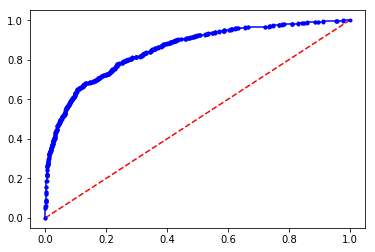

In [18]:
#get the roc curve to check if we are better than a random classifier
get_roc_curve(X_train, y_train,X_test, y_test, rf)

# El mejor modelo? 

Hemos usado un modelo muy básico, vamos a explorar algunas opciones extra en su configuración (de momento, sin tocar el dataset) para ver si conseguimos mejores resultados. Primero definiremos un espacio de busqueda de hiperparametros y luego probaremos 20 combinaciones aleatorias. Es importante que ya estamos especificando qué puntuación es la que queremos usar para elegir el mejor modelo salido de ésta exploración (F1 Score) ya que queremos balancear los aciertos de abandono y no abandono. Sin embargo, ésta elección siempre tiene que ir alineada con la métrica de negocio acordada con nuestros usuarios!

In [20]:
#tune our random forest
param_grid = {
    "max_depth": list(range(20, 300, 10)),
    "criterion":  ["gini", "entropy"],
    "max_features":  ["auto", "sqrt"],
    "min_samples_leaf": list(range(1, 5, 1)),
    "min_samples_split": list(range(2, 20, 2)),
    "n_estimators": [int(elems) for elems in list(np.logspace(np.log(100), np.log(800), base = np.exp(1), num = 30))]
}

#use 4 cores for each classifier and 2 models in parallel
rf = ensemble.RandomForestClassifier(n_jobs = 4)
n_iters = 20

random_search = model_selection.RandomizedSearchCV(estimator = rf, 
                                                   param_distributions = param_grid, 
                                                   n_iter = n_iters, scoring = 'f1', cv = 5, 
                                                   verbose = 1, n_jobs = 2)
random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   29.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Ahora que hemos explorado 20 opciones de configuración de hiperparametros, vamos a obtener la mejor y a ver el resultado sobre nuestro dataset de test

In [21]:
#get our best estimator
best_rf = random_search.best_estimator_ 

#show best parameters
best_params_rf = random_search.best_params_
print('Best observed parameters are: ', best_params_rf)

#predict using our test set and print different error measures
from sklearn import metrics

preds_proba_rf = best_rf.predict_proba(X=X_test)
preds_rf = best_rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Confusion matrix: \n", confusion_matrix(y_test, preds_rf))

Best observed parameters are:  {'n_estimators': 645, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 180, 'criterion': 'entropy'}
Accuracy:  0.86
Precision:  0.45
Recall:  0.79
F1:  0.57
Confusion matrix: 
 [[2322   73]
 [ 332  273]]


Precision ha subido un 6% y F1 Score (la media armónica entre Precision y Recall) también lo hace en un 5%... para una exploración sencilla no es mal avance!

# El problema del desbalanceo

Además de mejorar el algoritmo en sus parámetros, la gran mayoría de los casos en Machine Learning la clave está en los datos. Su calidad, su completitud, cómo los tratamos y codificamos, cómo los combinamos... es lo que realmente marca la diferencia en los resultados finales. 

Ya sabíamos que el abandono de clientes es, por definición, un problema de clasificación binaria desbalanceado, con más casos de un tipo ('no abandona') que del otro ('abandona'). 

Vamos a aplicar varias técnicas de supersampleo de datos para equilibrar el dato y hacer que nuestro algoritmo aprenda sobre más ejemplos de la clase minoritaria. Vamos a probar SMOTE, ADASYN y SVMSMOTE, pero dependiendo del caso de negocio habría que probar diferentes aproximaciones, así como de infrasampleo o quizás métodos híbridos.

In [22]:
#load our imbalanced label library
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE

#OVERSAMPLING
sampler_smote = SMOTE(n_jobs = -1)
sampler_svm =  SVMSMOTE(n_jobs = -1)
sampler_adasyn = ADASYN(n_jobs = -1)

X_smote, y_smote = sampler_smote.fit_resample(X = X_train, y=y_train.ravel())
X_svm, y_svm = sampler_svm.fit_resample(X = X_train, y=y_train.ravel())
X_adasyn, y_adasyn = sampler_adasyn.fit_resample(X = X_train, y=y_train.ravel())

print(X_smote.shape, X_svm.shape, X_adasyn.shape)

Using TensorFlow backend.
(11136, 10) (11136, 10) (11159, 10)


Ahora tenemos bastantes más filas en el conjunto de entrenamiento. Ahora tenemos unas 11.000 cuando antes teníamos 7.000, resultado de añadir casos "ficticios" pero que se parecen suficiente a los que integraban nuestra clase minoritaria (abandona) como para que el algoritmo los use para mejorar su aprendizaje. 

Además, vamos a usar una versión del RandomForestClassifier en el que coge subconjuntos de datos balanceados en lo que respecta a la distribución de la clase para cada árbol que construye, sin tocar el dato de entrenamiento original. 

In [23]:

#baseline
rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())

#FROM NOW ON, USE THE TUNED VERSION ALTHOUGH WE SHOULD RE-TUNE
#weight classes using the model itself
rf_balanced = ensemble.RandomForestClassifier(n_jobs=-1,
                                              class_weight = "balanced_subsample", ##VERY IMPORTANT
                                              **best_params_rf)
rf_balanced.fit(X = X_train, y=y_train.ravel())

#weight classes + smote
rf_balanced_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                                    class_weight = "balanced_subsample", ##VERY IMPORTANT
                                                    **best_params_rf) 
rf_balanced_smote.fit(X = X_smote, y=y_smote.ravel())

#default SMOTE
rf_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                            **best_params_rf)
rf_smote.fit(X = X_smote, y = y_smote.ravel())

#default SVM SMOTE
rf_svm = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_svm.fit(X = X_svm, y = y_svm.ravel())

#default ADASYN
rf_adasyn = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_adasyn.fit(X = X_adasyn, y = y_adasyn.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=180, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=645,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Vamos a obtener sus puntuaciones y a crear objetos para poder pintar una serie de gráficos comparando su rendimiento 

In [25]:
from sklearn import metrics

##VERY IMPORTANT: ALL MODELS HAVE BEEN TRAINED WITH DIFFERENT DATASETS BUT ALL ARE TESTED AGAINST THE SAME TEST
preds_rf_smote = rf_smote.predict(X=X_test)
preds_rf_svm = rf_svm.predict(X=X_test)
preds_rf_adasyn = rf_adasyn.predict(X=X_test)
preds_rf = rf.predict(X=X_test)
preds_rf_balanced = rf_balanced.predict(X=X_test)
preds_rf_balanced_smote = rf_balanced_smote.predict(X=X_test)

#%%
#PRINT RESULTS
print("Accuracy BASELINE:", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision BASELINE:", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall BASELINE:", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1 BASELINE:", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))

print("Accuracy BALANCED:", round(metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Precision BALANCED:", round(metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Recall BALANCED:", round(metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("F1 BALANCED:", round(metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE:", round(metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Precision SMOTE:", round(metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Recall SMOTE:", round(metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("F1 SMOTE:", round(metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE SVM:", round(metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Precision SMOTE SVM:", round(metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Recall SMOTE SVM:", round(metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("F1 SMOTE SVM:", round(metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))

print("Accuracy ADASYN:", round(metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Precision ADASYN:", round(metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Recall ADASYN:", round(metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("F1 ADASYN:", round(metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))

#create objects to plot
precision_baseline = metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel())
precision_smote = metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
precision_svm = metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
precision_adasyn = metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
precision_balanced = metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
precision_balanced_smote = metrics.precision_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

f1_baseline = metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel())
f1_smote = metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
f1_svm = metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
f1_adasyn = metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
f1_balanced = metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
f1_balanced_smote = metrics.f1_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

accuracy_baseline = metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel())
accuracy_smote = metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
accuracy_svm = metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
accuracy_adasyn = metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
accuracy_balanced = metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
accuracy_balanced_smote = metrics.accuracy_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

recall_baseline = metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel())
recall_smote = metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
recall_svm = metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
recall_adasyn = metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
recall_balanced = metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
recall_balanced_smote = metrics.recall_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

precision_scores = [precision_baseline, precision_balanced, precision_balanced_smote, precision_smote, precision_svm, precision_adasyn]
f1_scores = [f1_baseline, f1_balanced, f1_balanced_smote, f1_smote, f1_svm, f1_adasyn]
accuracy_scores = [accuracy_baseline, accuracy_balanced, accuracy_balanced_smote, accuracy_smote, accuracy_svm, accuracy_adasyn]
recall_scores = [recall_baseline, recall_balanced, recall_balanced_smote, recall_smote, recall_svm, recall_adasyn]
score_names = ["Baseline", "Balanced", "Balanced_SMOTE", "SMOTE", "SMOTE_SVM", "ADASYN"]

d_prec={'Scores':precision_scores, 'Version': score_names}
precision_scores_df = pd.DataFrame(d_prec)

d_f1={'Scores':f1_scores, 'Version': score_names}
f1_scores_df = pd.DataFrame(d_f1)

d_accuracy = {'Scores':accuracy_scores, 'Version': score_names}
accuracy_scores_df = pd.DataFrame(d_accuracy) 

d_recall = {'Scores':recall_scores, 'Version': score_names}
recall_scores_df = pd.DataFrame(d_recall) 
 

Accuracy BASELINE: 0.86
Precision BASELINE: 0.39
Recall BASELINE: 0.79
F1 BASELINE: 0.52
Accuracy BALANCED: 0.86
Precision BALANCED: 0.55
Recall BALANCED: 0.69
F1 BALANCED: 0.61
Accuracy SMOTE: 0.86
Precision SMOTE: 0.49
Recall SMOTE: 0.72
F1 SMOTE: 0.58
Accuracy SMOTE SVM: 0.86
Precision SMOTE SVM: 0.48
Recall SMOTE SVM: 0.73
F1 SMOTE SVM: 0.58
Accuracy ADASYN: 0.86
Precision ADASYN: 0.49
Recall ADASYN: 0.72
F1 ADASYN: 0.58


Veamos los resultados...

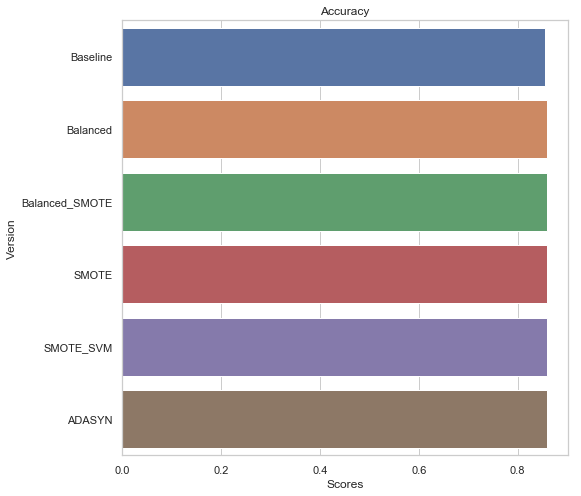

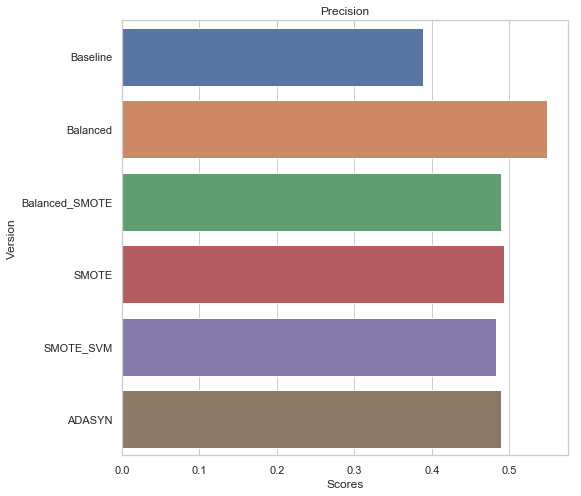

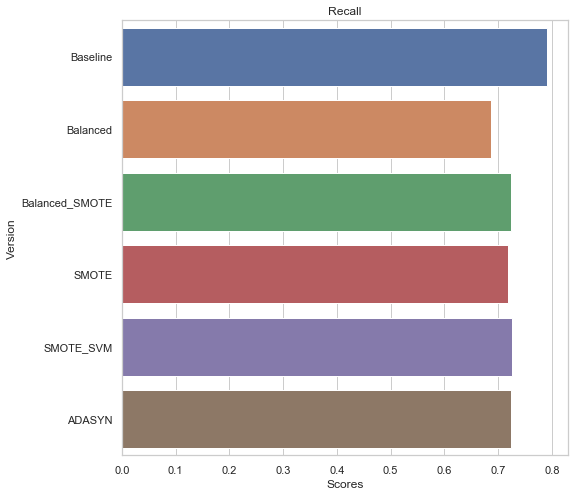

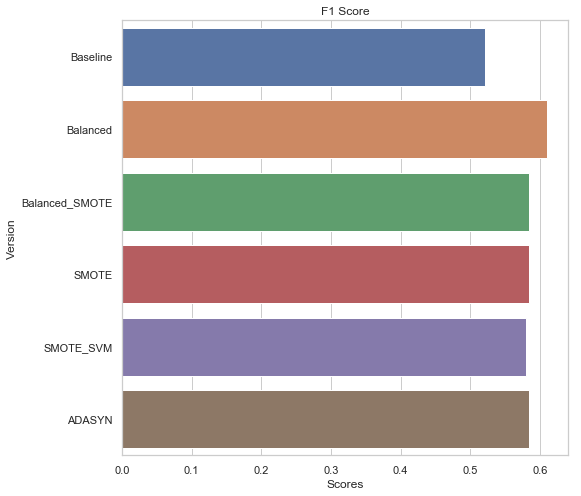

In [27]:
import seaborn as sns

#accuracy plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = accuracy_scores_df).set_title("Accuracy")

#%%
#precision plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = precision_scores_df).set_title("Precision")

#%%
#recall plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = recall_scores_df).set_title("Recall")

#%%
#f1 plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = f1_scores_df).set_title("F1 Score")

Vemos que el mejor resultado tanto en precision como en F1 Score lo ha obtenido la versión del modelo donde no tocamos el dato pero usamos una técnica de balanceo a través del algoritmo, con el RandomForestClassifer aprendiendo de subconjuntos del dato con la clase balanceada. Por tanto, ese será el modelo que usemos a partir de ahora

In [28]:
print("Accuracy BALANCED:", round(metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Precision BALANCED:", round(metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Recall BALANCED:", round(metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("F1 BALANCED:", round(metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))


Accuracy BALANCED: 0.86
Precision BALANCED: 0.55
Recall BALANCED: 0.69
F1 BALANCED: 0.61


Hemos mejorado un 10% la precision y un 4% el F1 Score sólo cambiando un parámetro en la creación del modelo... Si recuerdas nuestro artículo de introducción, por cada 5% que mejorabamos la retención de clientes podíamos incrementar el ingreso entre un 25 y un 95%! Que el modelo sea capaz de detectar dichos casos de abandono no nos asegura que vayamos a reducir la tasa en la que los clientes nos abandonan, pero por supuesto nos da herramientas para avanzarnos a ello y tomar medidas que sí pueden ayudar a fidelizar a nuestros clientes. 